In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)


#Explaratory Data Analysis

In [3]:
path = '/content/drive/My Drive/Data_Scientist_-_Case_Dataset.csv'
df= pd.read_csv(path, delimiter=",")

In [4]:
df.head(5)

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch;;;;
0,15001,0,13,male,22.0,1,0,14.5000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki;;;;
1,15002,1,11,female,38.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere;;;;
2,15003,1,13,female,26.0,0,0,15.8500,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki;;;;
3,15004,1,11,female,35.0,1,0,106.2000,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki;;;;
4,15005,0,13,male,35.0,0,0,16.1000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki;;;;


In [5]:
df.shape

(891, 10)

In [6]:
df = df.replace(['Helsinki;;;;'],'Helsinki')
df = df.replace(['Tampere;;;;'],'Tampere')
df = df.replace(['Turku;;;;'],'Turku')
df = df.rename(columns={'branch;;;;': 'branch'})

In [7]:
df.tail(5)

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
886,15887,0,12,male,27.0,0,0,26.0,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
887,15888,1,11,female,19.0,0,0,60.0,72294ba1616ddcaee48e56501040e876d26bd0c1839f3c...,Helsinki
888,15889,0,13,female,NaN,1,2,46.9,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
889,15890,1,11,male,26.0,0,0,60.0,a2b612f45840d6f27b1a73ddae7f50e0bd9c4935903de6...,Tampere
890,15891,0,13,male,32.0,0,0,15.5,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Turku


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        891 non-null    int64  
 1   converted          891 non-null    int64  
 2   customer_segment   891 non-null    int64  
 3   gender             891 non-null    object 
 4   age                714 non-null    float64
 5   related_customers  891 non-null    int64  
 6   family_size        891 non-null    int64  
 7   initial_fee_level  891 non-null    float64
 8   credit_account_id  891 non-null    object 
 9   branch             891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [9]:
df.describe()

,customer_id,converted,customer_segment,age,related_customers,family_size,initial_fee_level
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,15446.000000,0.383838,12.308642,29.699118,0.523008,0.381594,64.408416
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,99.386857
min,15001.000000,0.000000,11.000000,0.420000,0.000000,0.000000,0.000000
25%,15223.500000,0.000000,12.000000,20.125000,0.000000,0.000000,15.820800
50%,15446.000000,0.000000,13.000000,28.000000,0.000000,0.000000,28.908400
75%,15668.500000,1.000000,13.000000,38.000000,1.000000,0.000000,62.000000
max,15891.000000,1.000000,13.000000,80.000000,8.000000,6.000000,1024.658400


There are some strange numbers in age column, also some missing values.

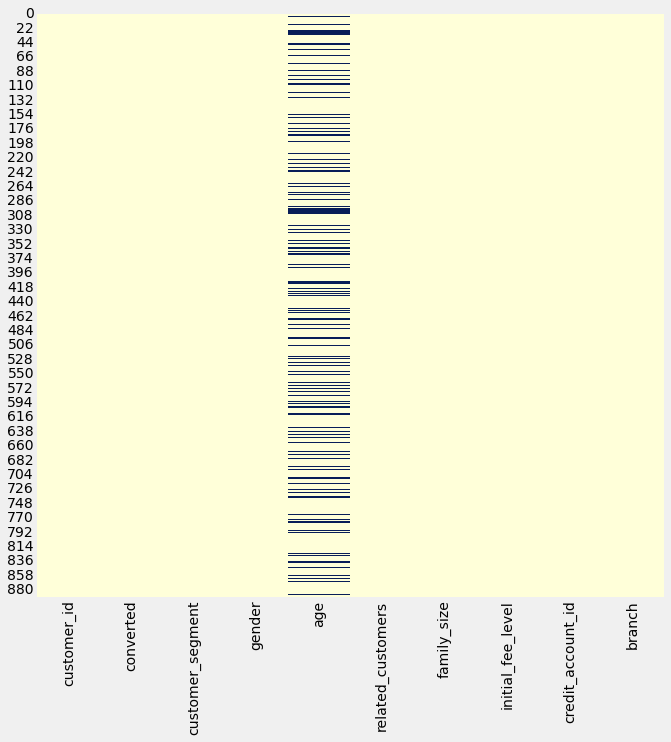

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isnull(), cbar = False, cmap = 'YlGnBu')

In [11]:
colstats = {}
for col in df.columns:
    colstats[col] = [df[col].isnull().sum(),df[col].isnull().sum()*100/df.shape[0],
                len(df[col].unique()),len(df[col].unique())*100/df.shape[0]] 
    
stats_col = pd.DataFrame(colstats.values(), index = colstats.keys(),  columns = ['Number of Null','% of Null','Number of Unique','% of Unique'])
pd.set_option('precision',2)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
print(stats_col)

                   Number of Null  % of Null  Number of Unique  % of Unique
customer_id                     0        0.0               891        100.0
converted                       0        0.0                 2          0.2
customer_segment                0        0.0                 3          0.3
gender                          0        0.0                 2          0.2
age                           177       19.9                89         10.0
related_customers               0        0.0                 7          0.8
family_size                     0        0.0                 7          0.8
initial_fee_level               0        0.0               248         27.8
credit_account_id               0        0.0               148         16.6
branch                          0        0.0                 4          0.4


In [12]:
df['converted'].value_counts()

0    549
1    342
Name: converted, dtype: int64

There is an imbalance in the output values.

In [13]:
df['gender'].value_counts()

male      577
female    314
Name: gender, dtype: int64

In [14]:
df['customer_segment'].value_counts()

13    491
11    216
12    184
Name: customer_segment, dtype: int64

In [15]:
df['branch'].value_counts()

Helsinki    644
Tampere     168
Turku        77
;;;;          2
Name: branch, dtype: int64

There is two missing values in branch column too. We will delete them.

In [16]:
df2 = df[df['age'].between(0, 15)]

In [17]:
df2.shape

(83, 10)

There are 83 lines between age (0,15)

In [18]:
df3 = df[df['age'].between(0, 5)]

In [19]:
df3.shape

(44, 10)

There are 44 lines between age (0,5). It is a bit strange, because the health apps must be used after 15.
(Here, I may need more domain knowledge about data)

In [20]:
df.mean()

customer_id         15446.0
converted               0.4
customer_segment       12.3
age                    29.7
related_customers       0.5
family_size             0.4
initial_fee_level      64.4
dtype: float64

##Imputation

I will do mean imputation since i do not want to lose the 20% of the data.

In [21]:
df = df.fillna(df.mean())

In [22]:
df.tail(5)

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
886,15887,0,12,male,27.0,0,0,26.0,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
887,15888,1,11,female,19.0,0,0,60.0,72294ba1616ddcaee48e56501040e876d26bd0c1839f3c...,Helsinki
888,15889,0,13,female,29.7,1,2,46.9,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
889,15890,1,11,male,26.0,0,0,60.0,a2b612f45840d6f27b1a73ddae7f50e0bd9c4935903de6...,Tampere
890,15891,0,13,male,32.0,0,0,15.5,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Turku


##Cleaning the absurd data.

I will delete the columns with age under 12.

In [23]:
dfnew = df[df['age'].between(12, 80)]

In [24]:
dfnew.shape

(823, 10)

In [25]:
dfnew['family_size'].value_counts()

0    676
1     83
2     49
5      5
3      5
4      4
6      1
Name: family_size, dtype: int64

In [26]:
dfnew['initial_fee_level'].value_counts()

16.1    43
26.0    42
15.8    38
15.5    34
52.0    28
        ..
14.1     1
14.3     1
31.5     1
68.0     1
17.4     1
Name: initial_fee_level, Length: 242, dtype: int64

In [27]:
dfnew['credit_account_id'].value_counts()

9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0    630
f0d3a2a5176986eddfdd60b0b303d8fd7c4dfe3060479feee41224ef86f7174a      4
16ee13fe0dd987f3ef966e930adebd1e4f5d40f6180ac7eadb416079d5c637f1      3
cec0a7de7f8d6fc385250a76e38555a1f45fd5aaeb1a2ba3dbdf90a049bb0681      3
3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0ebfda1a01ec05745d43      3
                                                                   ... 
72d639f06638a8bd2212fe30825432dcfeb6060899122be2bd41ac34a6e87071      1
241a58e62224983283f443df870777a779db375012000e524e8c5d42cc4beede      1
93e69677a8c96f1c47ce45b15b5170ec77bb5acd22f147dee343bf75fa821fb2      1
1b8109664cb6e461f4d7c4ff37c06bae5f3de0a41e500c577bef8b7eca3578ed      1
14a839c6693b8068f90616e2fd312dfbefc3a2099b1498093c7e15a8a74aa215      1
Name: credit_account_id, Length: 146, dtype: int64

Cleaning the rows with empty branch.

In [28]:
i = dfnew[(dfnew.branch == ';;;;')].index

In [29]:
dfnew = dfnew.drop(i)

In [30]:
dfnew.shape

(821, 10)

I feel that credit account id can give us information about the loyalty of the customers. Since if you trust and continue to work with the company you give them your creit account data. I change this part to a categorical variable.

In [31]:
for i in dfnew[(dfnew.credit_account_id != '9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0')].index:
    dfnew.loc[i, "credit_account_id"] = 0

In [32]:
for i in dfnew[(dfnew.credit_account_id == '9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0')].index:
    dfnew.loc[i, "credit_account_id"] = 1

We do not need customer id, delete it.

In [33]:
dfnew.drop('customer_id', axis=1, inplace=True)

In [34]:
dfnew.head(5)

,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
0,0,13,male,22.0,1,0,14.5,1,Helsinki
1,1,11,female,38.0,1,0,142.6,0,Tampere
2,1,13,female,26.0,0,0,15.8,1,Helsinki
3,1,11,female,35.0,1,0,106.2,0,Helsinki
4,0,13,male,35.0,0,0,16.1,1,Helsinki


Lastly, I will turn age column into a a categorical variable: age range. Let''s first look at the distribution of the ages.

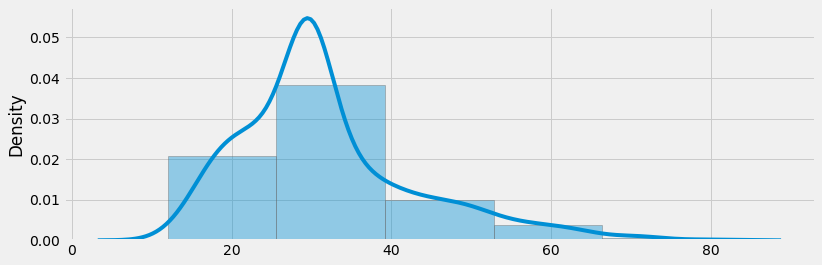

In [37]:
plt.figure(figsize=(12,4))
sns.distplot(dfnew['age'].values, bins=5)

In [38]:
bins_q = pd.IntervalIndex.from_tuples([(14, 25), (25, 40), (40, 50), (50, 80)])

dfnew['age_range'] = pd.cut(dfnew['age'], bins=bins_q)

In [39]:
dfnew.head(3)

,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch,age_range
0,0,13,male,22.0,1,0,14.5,1,Helsinki,"(14, 25]"
1,1,11,female,38.0,1,0,142.6,0,Tampere,"(25, 40]"
2,1,13,female,26.0,0,0,15.8,1,Helsinki,"(25, 40]"


#Different feature selection methods.

##CHI-Square TEST
It is a is a statistical test applied to the groups of categorical features to evaluate the likelihood of correlation or association between them using their frequency distribution.

In [40]:
X = dfnew[["customer_segment", "gender", "related_customers", "family_size", "credit_account_id", "branch", "age_range"]]
y = dfnew[["converted"]]

In [41]:
X.head(5)

,customer_segment,gender,related_customers,family_size,credit_account_id,branch,age_range
0,13,male,1,0,1,Helsinki,"(14, 25]"
1,11,female,1,0,0,Tampere,"(25, 40]"
2,13,female,0,0,1,Helsinki,"(25, 40]"
3,11,female,1,0,0,Helsinki,"(25, 40]"
4,13,male,0,0,1,Helsinki,"(25, 40]"


In [42]:
y.head(5)

,converted
0,0
1,1
2,1
3,1
4,0


In [43]:
X = X.astype(str)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [46]:
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (574, 7) (574, 1)
Test (247, 7) (247, 1)


In [47]:
def prepare_inputs(X_train, X_test):
	oe = OneHotEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

In [48]:
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

The scikit-learn machine library provides an implementation of the chi-squared test in the chi2() function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class.

In [49]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

In [50]:
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

Feature 0: 45.743113
Feature 1: 0.059083
Feature 2: 24.295024
Feature 3: 121.491292
Feature 4: 61.542833
Feature 5: 3.592248
Feature 6: 10.526618
Feature 7: 0.186085
Feature 8: 5.046729
Feature 9: 0.138344
Feature 10: 0.594444
Feature 11: 3.566667
Feature 12: 1.822730
Feature 13: 5.743310
Feature 14: 4.451125
Feature 15: 2.433658
Feature 16: 2.377778
Feature 17: 0.258061
Feature 18: 0.594444
Feature 19: 45.081062
Feature 20: 13.330969
Feature 21: 4.773117
Feature 22: 10.618776
Feature 23: 1.184666
Feature 24: 0.030339
Feature 25: 0.029550
Feature 26: 0.245102
Feature 27: 0.057377
Feature 28: 1.180841


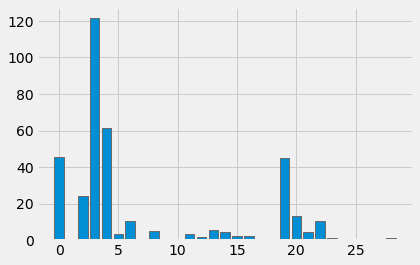

In [51]:
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

Since we make the features one hot encoded, we have 28 features now. It seems that customer segment, gender and credit account have large affect on the output value.

I want to try it with ordinal encoding. Some variables in the data are suitable with this encoding.

In [52]:
def prepare_inputs2(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

In [53]:
X_train_enc, X_test_enc = prepare_inputs2(X_train, X_test)

Feature 0: 39.901094
Feature 1: 61.542833
Feature 2: 2.430977
Feature 3: 5.220726
Feature 4: 13.330969
Feature 5: 11.720108
Feature 6: 0.221257


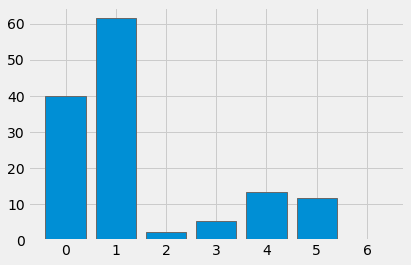

In [54]:
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

This gives similar results: gender, customer segment, credit account and branch are dominant features in descending order.

In [57]:
from sklearn.feature_selection import mutual_info_classif

Mutual information from the field of information theory is the application of information gain (typically used in the construction of decision trees) to feature selection

In [55]:
def select_features3(X_train, y_train, X_test):
	fs = SelectKBest(score_func=mutual_info_classif, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

Feature 0: 0.038391
Feature 1: 0.161592
Feature 2: 0.000000
Feature 3: 0.009526
Feature 4: 0.043232
Feature 5: 0.014291
Feature 6: 0.000000


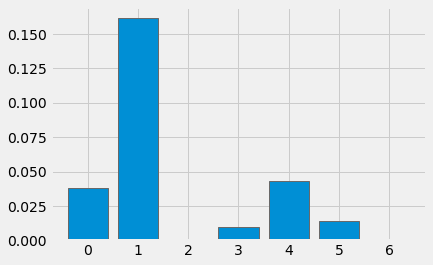

In [58]:
X_train_fs, X_test_fs, fs = select_features3(X_train_enc, y_train, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

Again, this is telling us that gender, customer segmentcredit account and branch are important features. 

##Logistic regression model

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [60]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_enc, y_train)
# evaluate the model
yhat = model.predict(X_test_enc)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 85.02


In [61]:
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k=4)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

In [62]:
X_train_fs, X_test_fs = select_features(X_train_enc, y_train, X_test_enc)

In [63]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 83.00


In [64]:
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=mutual_info_classif, k=4)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

In [65]:
X_train_fs, X_test_fs = select_features(X_train_enc, y_train, X_test_enc)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 83.81


From computational perspective, this data points and 8 features for logistic regression is nothing, i.e., the computer can return results in seconds.

On the other and, if you do feature selection, in most cases, the performance (classification accuracy) will be worse. This is because, intuitively, more information does not hurt, even the feature is completely irrelevant to the label, the algorithm will just set the coefficient to zero.
In here our focus is interpratation of features not classification accuracy, of course.


In [67]:
dfnew['converted'].value_counts()

0    520
1    301
Name: converted, dtype: int64

In [66]:
from sklearn.metrics import confusion_matrix

In [68]:
confusion_matrix(yhat, y_test, labels=[1,0])

array([[ 66,  19],
       [ 21, 141]])

In [70]:
from sklearn.metrics import recall_score
recall_score(y_test, yhat)

0.7586206896551724

I am guessing thet this data set is for a churn modelling. If it is so, this is the measure we really care about, because we want to miss as few of the true Churn cases as possible. In here our main focus is feature selection.

##XG-boost

I will add here the numeriacal feature initial fee  and I want to look all categorcal and numerical features together. I will use XG-BOOST. A benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

In [75]:
dfnew.head(3)

,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch,age_range
0,0,13,male,22.0,1,0,14.5,1,Helsinki,"(14, 25]"
1,1,11,female,38.0,1,0,142.6,0,Tampere,"(25, 40]"
2,1,13,female,26.0,0,0,15.8,1,Helsinki,"(25, 40]"


Here I am using another method for encoding.

In [76]:
df = pd.concat([dfnew,pd.get_dummies(dfnew['customer_segment'], prefix='cs')],axis=1).drop(['customer_segment'],axis=1)
df = pd.concat([df,pd.get_dummies(dfnew['related_customers'], prefix='rcust')],axis=1).drop(['related_customers'],axis=1)
df = pd.concat([df,pd.get_dummies(dfnew['gender'], prefix='g')],axis=1).drop(['gender'],axis=1)
df = pd.concat([df,pd.get_dummies(dfnew['family_size'], prefix='fs')],axis=1).drop(['family_size'],axis=1)
df = pd.concat([df,pd.get_dummies(dfnew['branch'], prefix='br')],axis=1).drop(['branch'],axis=1)
df = pd.concat([df,pd.get_dummies(dfnew['age_range'], prefix='age')],axis=1).drop(['age_range'],axis=1)

In [77]:
df.drop('age', axis=1, inplace=True)

In [78]:
df.head(3)

,converted,initial_fee_level,credit_account_id,cs_11,cs_12,cs_13,rcust_0,rcust_1,rcust_2,rcust_3,rcust_4,rcust_5,rcust_8,g_female,g_male,fs_0,fs_1,fs_2,fs_3,fs_4,fs_5,fs_6,br_Helsinki,br_Tampere,br_Turku,"age_(14, 25]","age_(25, 40]","age_(40, 50]","age_(50, 80]"
0,0,14.5,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0
1,1,142.6,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
2,1,15.8,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0


In [79]:
dataset = df.values

In [80]:
X = dataset[:,1:29]
y = dataset[:,0:1]

[0.02499724 0.07541436 0.01024901 0.02384983 0.20146641 0.01984848
 0.01153265 0.00447425 0.         0.         0.         0.01403157
 0.44484344 0.         0.02713968 0.         0.         0.
 0.         0.         0.         0.03802271 0.02189871 0.
 0.00929685 0.02787331 0.03169228 0.01336933]


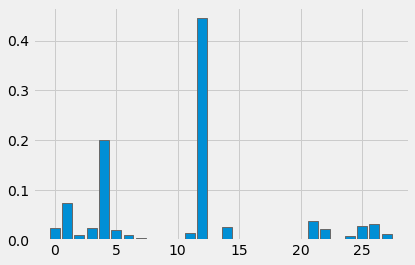

In [81]:

# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot

model = XGBClassifier()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

Here we see that gender, segment, initial fee, branch are effective and here age also have some importance.

##LightGBM Method 
We will use a Gradient Boosted Model from the LightGBM library to assess feature importances. The LightGBM library has an API that makes deploying the model very similar to using a Scikit-Learn model.

In [82]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [83]:
df.head(2)

,converted,initial_fee_level,credit_account_id,cs_11,cs_12,cs_13,rcust_0,rcust_1,rcust_2,rcust_3,rcust_4,rcust_5,rcust_8,g_female,g_male,fs_0,fs_1,fs_2,fs_3,fs_4,fs_5,fs_6,br_Helsinki,br_Tampere,br_Turku,"age_(14, 25]","age_(25, 40]","age_(40, 50]","age_(50, 80]"
0,0,14.5,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0
1,1,142.6,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [84]:
df=df.astype('uint8')

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 821 entries, 0 to 890
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   converted          821 non-null    uint8
 1   initial_fee_level  821 non-null    uint8
 2   credit_account_id  821 non-null    uint8
 3   cs_11              821 non-null    uint8
 4   cs_12              821 non-null    uint8
 5   cs_13              821 non-null    uint8
 6   rcust_0            821 non-null    uint8
 7   rcust_1            821 non-null    uint8
 8   rcust_2            821 non-null    uint8
 9   rcust_3            821 non-null    uint8
 10  rcust_4            821 non-null    uint8
 11  rcust_5            821 non-null    uint8
 12  rcust_8            821 non-null    uint8
 13  g_female           821 non-null    uint8
 14  g_male             821 non-null    uint8
 15  fs_0               821 non-null    uint8
 16  fs_1               821 non-null    uint8
 17  fs_2            

In [94]:
y=y.astype('uint8')

In [86]:
dfX = df.drop('converted', axis=1, inplace=True)

In [87]:
feature_importances = np.zeros(X.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [95]:
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(df, y, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

In [96]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(df.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
0,initial_fee_level,21804.0
25,"age_(25, 40]",6728.0
24,"age_(14, 25]",4091.0
21,br_Helsinki,3683.5
12,g_female,2680.5


In [97]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 10 features with 0.0 importance


,feature,importance
17,fs_3,0.0
16,fs_2,0.0
8,rcust_3,0.0
9,rcust_4,0.0
19,fs_5,0.0


In [98]:
def plot_feature_importances(df, threshold = 0.9):
  
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

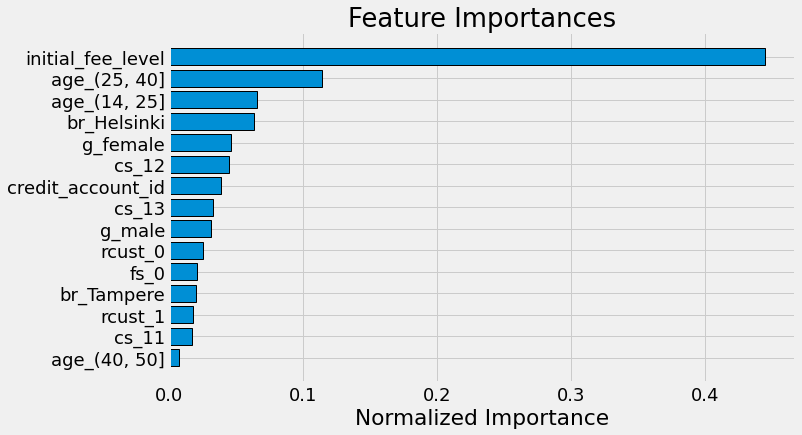

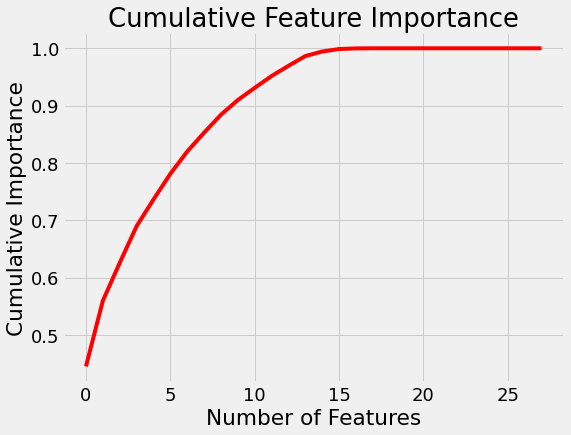

10 features required for 0.90 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

Here, we realize that initial fee level, age gender, branch, customer segmentation and credit account id are important features. Family size and related customer are irrelevant.